# <center> Biomedical Image Segmentation with U-Net</center>

<a id="ToC"></a>
# Table of Contents
- [1. Introduction](#1)
- [2. Imports](#2)
- [3. Data Loading and Preperation](#3)
    - [3.1 Exploring data](#3.1)
    - [3.2 Loading data](#3.2)
- [4. EDA](#4)
    - [4.1 Data of each class ](#4.1)
    - [4.2 Average view of masks each class](#4.2)
- [5. Data Pre-Processing](#5)    
- [6. Modeling](#6)
    - [6.1 Building U-Net Architecture](#6.1)
    - [6.2 Training](#6.2)
- [7. Evaluation](#7)   

<a id="1"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Introduction </span></center></div>**

### About Dataset

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning. 

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

## What is U-Net?

- **U-Net** is a popular deep-learning **architecture for semantic segmentation**. Originally developed for **medical images**, it had great success in this field. But, that was only the beginning! From satellite images to handwritten characters, the architecture has improved performance on a range of data types.
- The **U-Net architecture** has been widely used in various medical image segmentation tasks, such as **brain tumor segmentation, lung segmentation, and cell segmentation**, among others.

### U-Net: Convolutional Networks for Biomedical Image Segmentation

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

- U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.

- This illustration is an example of Unet architecture but layers can have different size.

**We apply it for breast cancer image segmentation with some modifications to the model.**

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Imports </span></center></div>**

In [16]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


# Metrics
from tensorflow.keras.metrics import *

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Data Loading and Preparation </span></center></div>**

<a id="3.1"></a>
## <span style="color:#08bf2c;"> Exploring data : </span>

In [17]:
# glob: function that's used to search for files that match a specific file pattern or name
paths = glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*')

print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [18]:
sorted(glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/*'))[4:7]

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png']

### Some images have 2 or more masks. Combine them into one image.

<a id="3.2"></a>
## <span style="color:#08bf2c;"> Loading data </span>

Functions

In [19]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

#loading data for binary segmentation
def load_data(root_path, size):
    images = []
    masks = []
    
    x = 0   # additional variable to identify images consisting of 2 or more masks
    
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image
            
        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask
                    
                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [20]:
size = 128   # image size: 128x128
X, y = load_data('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*', size)

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> EDA </span></center></div>**

<a id="4.1"></a>
## <span style="color:#08bf2c;"> Data of each class </span>

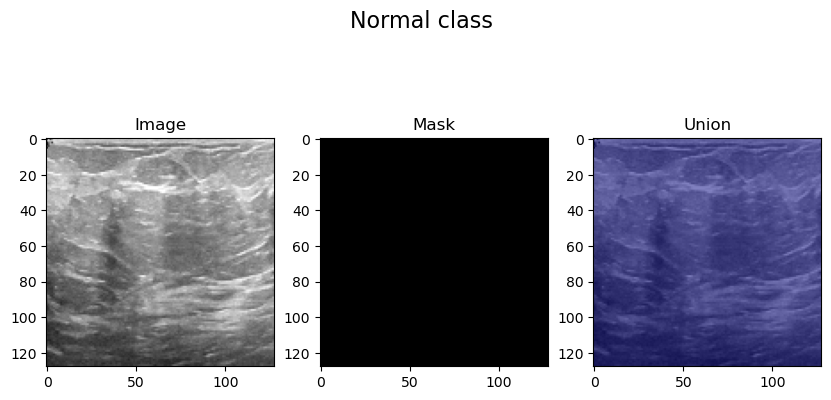

In [21]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

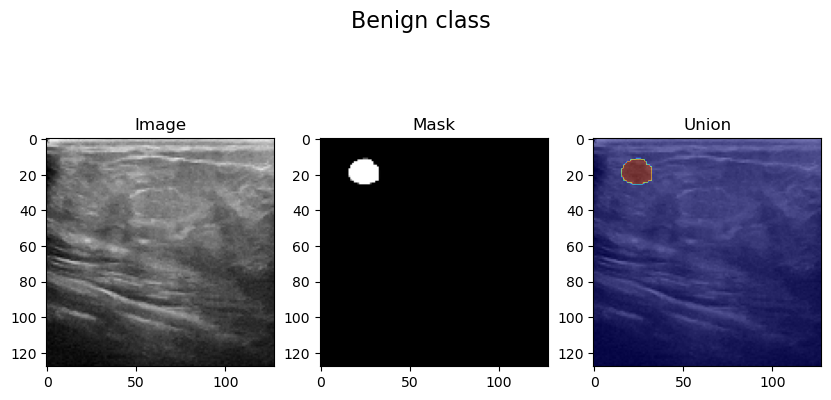

In [22]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

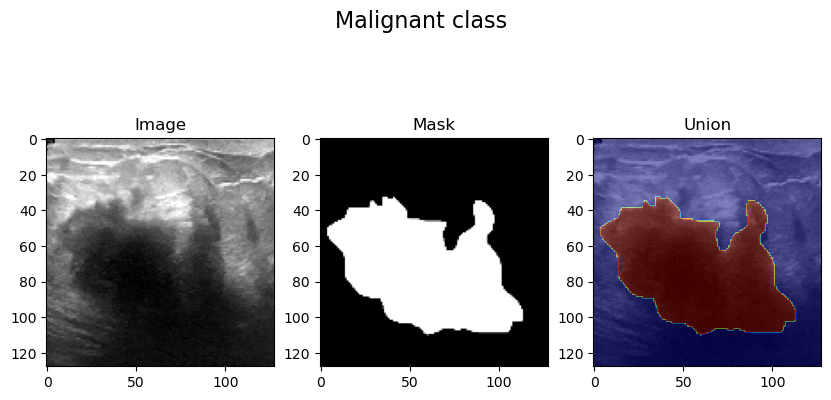

In [23]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

<a id="4.2"></a>
## <span style="color:#08bf2c;"> Average view of masks each class </span>

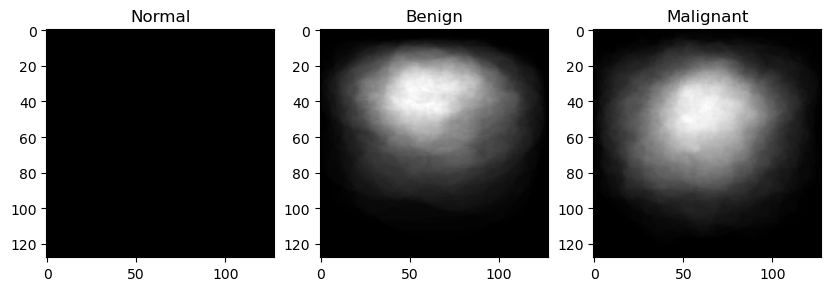

In [24]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="5"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Data Pre-Processing </span></center></div>**

### <span style="color:#2981d9;"> Prepare data to modeling </span>

In [25]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


### <span style="color:#2981d9;"> Train-test split </span>

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="6"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Modeling </span></center></div>**

<a id="6.1"></a>
## <span style="color:#08bf2c;"> Building U-Net Architecture </span>

### <span style="color:#2981d9;"> Conv block </span>

In [27]:

#Batch normalization helps by normalizing the activations of the previous layer for each mini-batch 
#during training, making the network less sensitive to the scale of the input data and improving 
#convergence. It also introduces a regularizing effect that can reduce overfitting.

def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = BatchNormalization()(conv)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    return conv

### <span style="color:#2981d9;"> Encoder block </span>

In [28]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

### <span style="color:#2981d9;"> Decoder block </span>

In [29]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

### <span style="color:#2981d9;"> Build model </span>

In [30]:
def build_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    #if trained for multi classification
    #output_layer = Conv2D(3, 1, padding="same", activation="softmax")(d4)

    
    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
#for multiclass classification
#model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

### <span style="color:#2981d9;"> Model plotting </span>

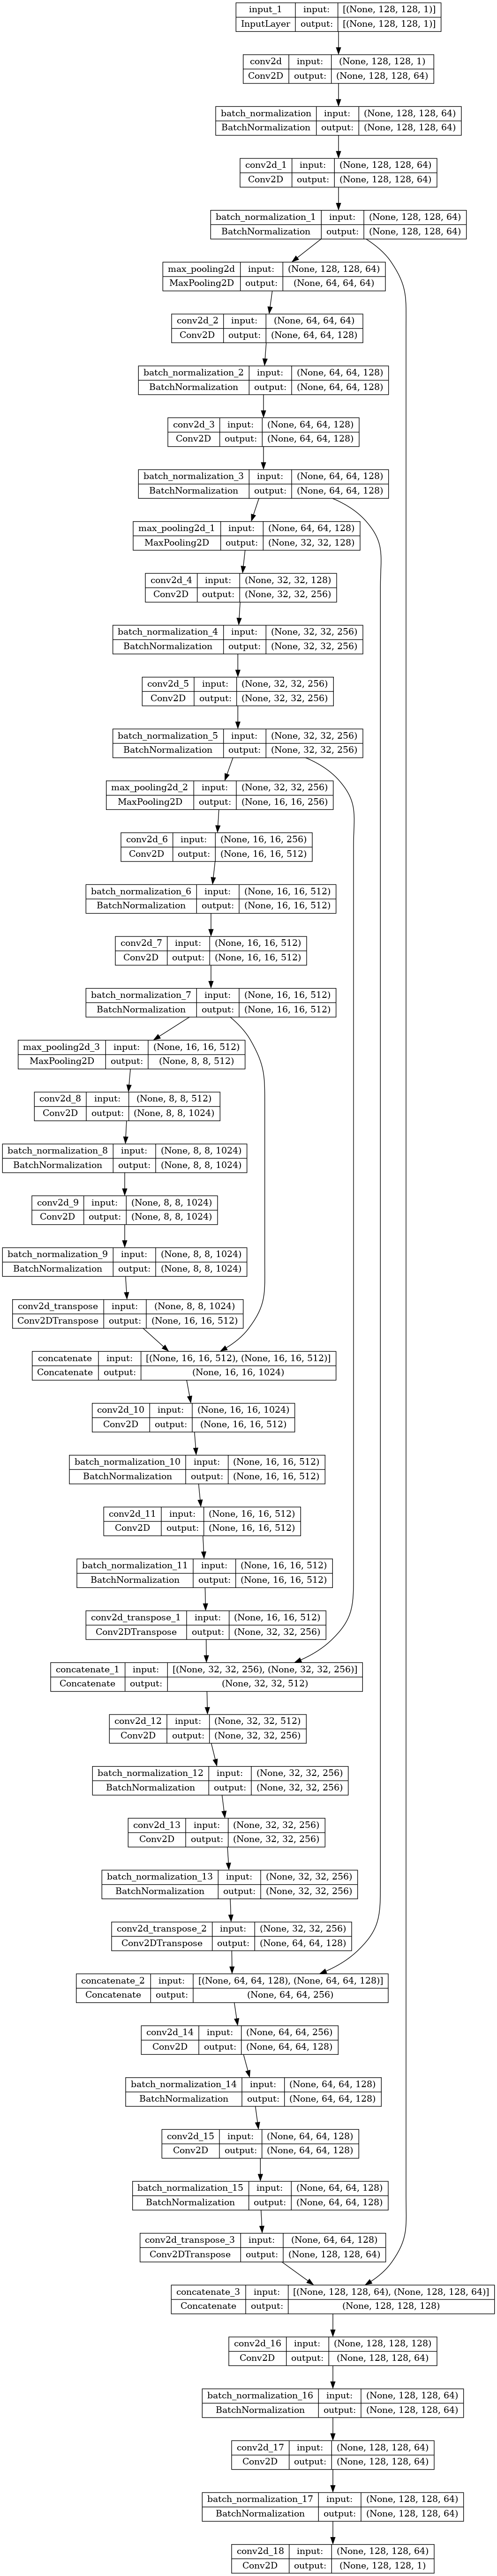

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

### <span style="color:#2981d9;"> Model summary </span>

In [32]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

<a id="6.2"></a>
## <span style="color:#08bf2c;"> Training </span>

In [33]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
19/19 [==============================] - 32s 335ms/step - loss: 0.6774 - accuracy: 0.6730 - val_loss: 112926.2031 - val_accuracy: 0.0920
Epoch 2/100
19/19 [==============================] - 4s 202ms/step - loss: 0.4607 - accuracy: 0.9114 - val_loss: 77904.1406 - val_accuracy: 0.0920
Epoch 3/100
19/19 [==============================] - 4s 202ms/step - loss: 0.3620 - accuracy: 0.9306 - val_loss: 8976.5742 - val_accuracy: 0.0920
Epoch 4/100
19/19 [==============================] - 4s 201ms/step - loss: 0.3060 - accuracy: 0.9345 - val_loss: 5766.1787 - val_accuracy: 0.0920
Epoch 5/100
19/19 [==============================] - 4s 202ms/step - loss: 0.2624 - accuracy: 0.9394 - val_loss: 957.9491 - val_accuracy: 0.1100
Epoch 6/100
19/19 [==============================] - 4s 202ms/step - loss: 0.2339 - accuracy: 0.9424 - val_loss: 194.9770 - val_accuracy: 0.2787
Epoch 7/100
19/19 [==============================] - 4s 202ms/step - loss: 0.1985 - accuracy: 0.9463 - val_loss: 45.8944 -

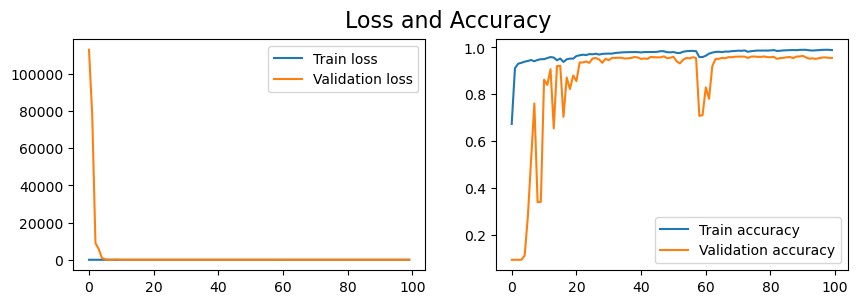

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="7"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Evaluation </span></center></div>**

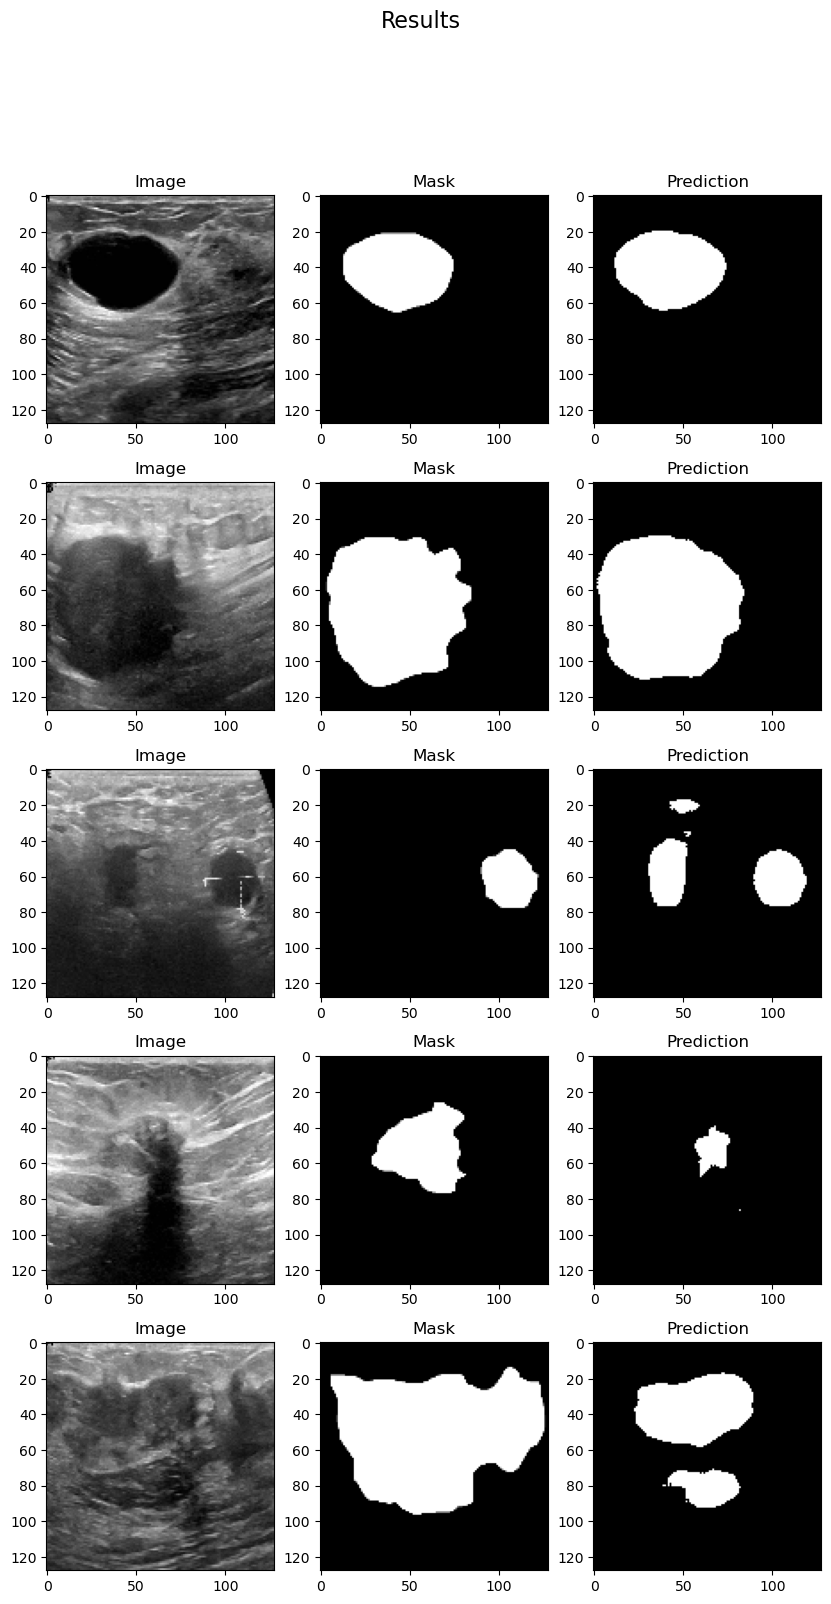

In [35]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    #model accepts batch of images
    predicted_mask = model.predict(np.expand_dims(X_test[j[i]], 0), verbose=0)[0] #adds an extra dimension to the image to form a batch of size 1.
    binary_mask = (predicted_mask > 0.5).astype('float32')  # Apply threshold
    ax[i,2].imshow(binary_mask, cmap='gray')
    ax[i,2].set_title('Prediction')
    
fig.suptitle('Results', fontsize=16)
plt.show()

In [38]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5
# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())


#- Precision is the ratio of correctly predicted positive pixels to the total number of pixels 
#predicted as positive (true positives / predicted positives).

#- Recall is the ratio of correctly predicted positive pixels to all pixels that are actually positive (true positives / actual positives).

#- The F1 score is the harmonic mean of precision and recall, providing a balance between the two. It is a good metric when you want to balance between false positives and false negatives.

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

#dice score
def dice_metric(y_true, y_pred_thresholded):
    intersection = np.sum(y_true * y_pred_thresholded)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred_thresholded))

# A score of  0 indicates no overlap
#A score of 1 indicates perfect overlap
dice_score = dice_metric(y_test, y_pred_thresholded)
print('Dice Score = %.3f' % dice_score)


Mean IoU = 0.7844602
Precision Score = 0.742
Recall Score = 0.784
F1 Score = 0.762
Dice Score = 0.762


<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>